In [1]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from cliffs_delta import cliffs_delta

from ecoselekt.settings import settings

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

In [2]:
EXP_ID = "apch"
MODEL_HISTORY = 15

PROJECTS = [
    "activemq",
    "camel",
    "cassandra",
    "flink",
    "groovy",
    "hbase",
    "hive",
    "ignite",
]

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
all_latency_df = pd.DataFrame(columns=["project", "window", "commit_id", "eco_pred_time", "base_pred_time"])
for project in PROJECTS:
    latency_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{project}_inf_perf.csv")
    latency_df["project"] = project
    all_latency_df = pd.concat([all_latency_df, latency_df], ignore_index=True)

all_latency_df["eco_pred_time"] = all_latency_df["eco_pred_time"] * 1000
all_latency_df["base_pred_time"] = all_latency_df["base_pred_time"] * 1000

all_latency_df.head()

,project,window,commit_id,eco_pred_time,base_pred_time
0,activemq,15,014773936022e72b4f8fdff90a0f9fdc33c9b247,34.815311,27.503252
1,activemq,15,02538ed9061b1a57c1a8b0c5accff76465429da0,28.982878,15.810728
2,activemq,15,02ef3dc91846b209dbcf9b65cced501bda2d8280,29.370070,14.538050
3,activemq,15,0484af1c61ca26ce8ea7e2decf953052e0a7ad1e,31.594992,16.013145
4,activemq,15,093b0e2370ebd4c133fa2f110a39ac53dd1bb699,30.289888,14.490128


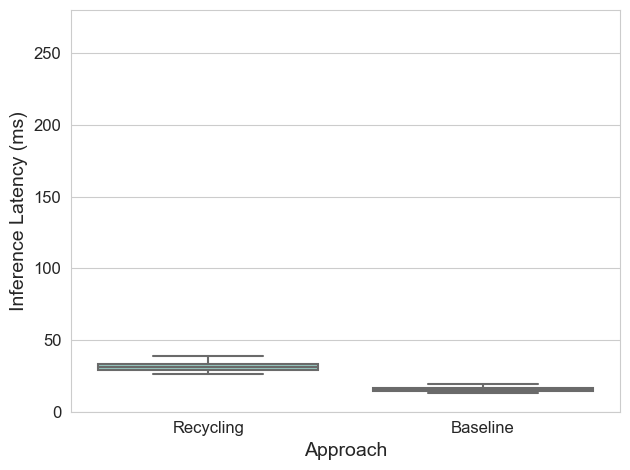

In [4]:
# plot boxplot of inference latency for both eco and base models in one plot
p = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(all_latency_df[["eco_pred_time", "base_pred_time"]].rename(columns={"eco_pred_time": "Recycling", "base_pred_time": "Baseline"})),
    palette="Set3",
    showfliers=False,
)
# start from 0 y-axis
p.set_ylim(0, 280)
# increase font size
p.tick_params(labelsize=12)
p.set_xlabel("Approach", fontsize=14)
p.set_ylabel("Inference Latency (ms)", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
ALPHA = 0.05

stat_df = pd.DataFrame(columns=["project", "significant", "effect_size"])

for project in PROJECTS:
    temp_df = all_latency_df[all_latency_df["project"] == project]
    _, p = wilcoxon(temp_df["eco_pred_time"], temp_df["base_pred_time"])
    print(f"Significant? -> {p < ALPHA}")
    res = None
    if p < ALPHA:
        d, res = cliffs_delta(temp_df["eco_pred_time"], temp_df["base_pred_time"])
        print(f"Cliff's Delta -> {d}, {res}")
    eco_med = temp_df["eco_pred_time"].median()
    base_med = temp_df["base_pred_time"].median()
    factor = eco_med / base_med
    print(f"Median factor -> {factor}")
    stat_df = stat_df.append({"project": project, "significant": p, "effect_size": res, "eco_med": eco_med, "base_med": base_med, "factor": factor}, ignore_index=True)

stat_df

Significant? -> True
Cliff's Delta -> 0.97023875, large
Median factor -> 2.016431723724241
Significant? -> True
Cliff's Delta -> 0.9826716903688287, large
Median factor -> 2.0171433810047703
Significant? -> True
Cliff's Delta -> 0.9912658125, large
Median factor -> 2.016606284887978
Significant? -> True
Cliff's Delta -> 0.9795733552631579, large
Median factor -> 2.0290473766967736
Significant? -> True
Cliff's Delta -> 0.9876186875, large
Median factor -> 1.9958166936202582
Significant? -> True
Cliff's Delta -> 0.9930524102079396, large
Median factor -> 1.9901710544440896
Significant? -> True
Cliff's Delta -> 0.989785331632653, large
Median factor -> 1.9882850453148178
Significant? -> True
Cliff's Delta -> 0.98880125, large
Median factor -> 2.0229717014145465


,project,significant,effect_size,eco_med,base_med,factor
0,activemq,0.0,large,33.661008,16.693354,2.016432
1,camel,0.0,large,31.475544,15.604019,2.017143
2,cassandra,0.0,large,30.921459,15.333414,2.016606
3,flink,0.0,large,31.842947,15.693545,2.029047
4,groovy,0.0,large,28.834939,14.447689,1.995817
5,hbase,0.0,large,29.278874,14.711738,1.990171
6,hive,0.0,large,29.761910,14.968634,1.988285
7,ignite,0.0,large,31.011105,15.329480,2.022972


In [6]:
print(stat_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrlrrr}
\toprule
  project &  significant & effect\_size &  eco\_med &  base\_med &  factor \\
\midrule
 activemq &        0.000 &       large &   33.661 &    16.693 &   2.016 \\
    camel &        0.000 &       large &   31.476 &    15.604 &   2.017 \\
cassandra &        0.000 &       large &   30.921 &    15.333 &   2.017 \\
    flink &        0.000 &       large &   31.843 &    15.694 &   2.029 \\
   groovy &        0.000 &       large &   28.835 &    14.448 &   1.996 \\
    hbase &        0.000 &       large &   29.279 &    14.712 &   1.990 \\
     hive &        0.000 &       large &   29.762 &    14.969 &   1.988 \\
   ignite &        0.000 &       large &   31.011 &    15.329 &   2.023 \\
\bottomrule
\end{tabular}

